In [27]:
import math
import torch
from torchvision import transforms as T
import torch.nn as nn
import torch.nn.functional as F
import gpytorch
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model

In [28]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.likelihood = likelihood

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [206]:
def train(model, neighbors, target):
    model.train()
    model.likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
    num_epochs = 200
    losses = []
    for i in range(num_epochs):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(neighbors)
        # Calc loss and backprop gradients
        loss = -mll(output, target)
        losses.append(loss.item())
        loss.backward()
        # print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        #     i + 1, num_epochs, loss.item(),
        #     model.covar_module.base_kernel.lengthscale.item(),
        #     model.likelihood.noise.item()
        # ))
        optimizer.step()
    return losses

In [207]:
def predict(model, neighbors):
    model.eval()
    model.likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        hi_res_prediction = model.likelihood(model(neighbors))
    return hi_res_prediction

# Helper functions

In [208]:
# visualization helpers 
def _remove_axes(ax):
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.set_xticks([])
    ax.set_yticks([])

def remove_axes(axes):
    if len(axes.shape) == 2:
        for ax1 in axes:
            for ax in ax1:
                _remove_axes(ax)
    else:
        for ax in axes:
            _remove_axes(ax)

In [218]:
def get_patches(image, kernel_size, stride):
    c = image.shape[1]
    patches = nn.Unfold(kernel_size=kernel_size, stride=stride)(image)
    b, image_size, grid_size = patches.shape
    grid_width, grid_height = int(math.sqrt(grid_size)), int(math.sqrt(grid_size))
    patches = patches.reshape(b, c, kernel_size, kernel_size, grid_width, grid_height)
    return patches

def get_model_inputs(patch):
    target = []
    neighbors = []
    input_kernel_size = 3

    b, c, patch_width, patch_height = patch.shape
    training = nn.Unfold(kernel_size=input_kernel_size, stride=input_kernel_size)(patch)
    training = training.reshape(1, c, input_kernel_size, input_kernel_size, patch_width // 3, patch_height // 3)
    b, c, input_width, input_height, grid_width, grid_height = training.shape

    for i in range(grid_width):
        for j in range(grid_height):
            y = training[:, :, 1, 1, i, j]
            X_NL = training[:, :, :, :, i, j]
            X_NL = X_NL.reshape(c, 1, 9).permute(1, 2, 0)
            X_NL = torch.cat([X_NL[:, :4, :], X_NL[:, 5:, :]], dim=1)

            target.append(y.squeeze())
            neighbors.append(X_NL.squeeze())

    target = torch.stack(target)
    neighbors = torch.stack(neighbors)

    return neighbors, target

def get_neighbors_per_pixel(patch, kernel_size=3, stride=1, padding=1):
    b, c, width, height = patch.shape
    padded_patch = nn.ReflectionPad2d(padding)(patch)
    neighbors = nn.Unfold(kernel_size=kernel_size, stride=stride)(padded_patch)
    neighbors = neighbors.reshape(b, 9, (width + padding*2 - kernel_size + stride)**2)
    neighbors = torch.cat([neighbors[:, :4, :], neighbors[:, 5:, :]], dim=1).permute(0, 2, 1)
    return neighbors

In [219]:
# blending patches together to get final image

def blend_patch(x0, x1, overlap, direction):
    xh0, xw0 = x0.shape
    xh1, xw1 = x1.shape
    dim_to_overlap = xw0
    other_dim = xh0
    
    if direction == 'v':
        x0 = x0.permute(1, 0)
        x1 = x1.permute(1, 0)
        dim_to_overlap = xh0
        other_dim = xw0

    xramp0 = dim_to_overlap - overlap
    xramp1 = 0

    x00 = x0[:, :xramp0]
    x01 = x0[:, xramp0:]

    x11 = x1[:, :overlap]
    x12 = x1[:, overlap:]

    ramp0 = torch.linspace(1, 0, overlap).repeat((other_dim, 1))
    ramp1 = 1 - ramp0

    blend_mid = x01 * ramp0 + x11 * ramp1

    blend = torch.cat([x00, blend_mid, x12], dim=1)
    
    if direction == 'v':
        blend = blend.permute(1, 0)
    return blend

def blend(patches, overlap, dims):
    h, w = dims
    curr_blend = None
    
    for i in range(h):
        row_blend = patches[i * w]
        for j in range(1, w):
            if w == 0 and h == 0:
                continue
            
            idx = i * w + j

            next_patch = patches[idx]
            row_blend = blend_patch(row_blend, next_patch, overlap, 'h')

        if curr_blend is None:
            curr_blend = row_blend
        else:
            curr_blend = blend_patch(curr_blend, row_blend, overlap, 'v')
    return curr_blend

# Upsample implementation

In [220]:
def show_loss_grid(losses):
    rows = len(losses)
    cols = len(losses[0])

    f, ax = plt.subplots(rows, cols, figsize=(cols, rows))
    
    for i in range(len(losses)):
        for j in range(len(losses[0])):
            ax[i, j].plot(losses[i][j])
    remove_axes(ax)
    plt.show()

In [221]:
def upsample(L, kernel_size, stride, scale_factor):
    print("UPSAMPLING")
    patches_L = get_patches(L, kernel_size=kernel_size, stride=stride)
    Hb = nn.Upsample(scale_factor=scale_factor, mode='bicubic')(L)
    Hb_patches = get_patches(Hb, kernel_size * scale_factor, stride=stride * scale_factor)
    upsample_losses = []
    preds = []
    for i in tqdm(range(patches_L.shape[-1])):
        row_losses = []
        for j in range(patches_L.shape[-1]):
            patch_L = patches_L[..., i, j]
            Xnl, y = get_model_inputs(patch_L)

            likelihood = gpytorch.likelihoods.GaussianLikelihood()
            model = ExactGPModel(Xnl, y, likelihood)
            losses = train(model, Xnl, y)
            
            row_losses.append(losses)
            
            Hb_patch = Hb_patches[..., i, j]
            inference = get_neighbors_per_pixel(Hb_patch)
            observed_pred = predict(model, inference)
            
            s = int(math.sqrt(observed_pred.loc.shape[-1]))
            preds.append(observed_pred.loc.reshape(s, s))
        upsample_losses.append(row_losses)

    s = Hb_patches.shape[-1]
    blended = blend(preds, overlap=(kernel_size - stride) * scale_factor, dims=(s, s))
    
    show_loss_grid(upsample_losses)
    
    return blended.unsqueeze(0)

# Deblur implementation

In [222]:
def deblur(Hb, L, Lb, kernel_size, stride):
    print("DEBLURRING")
    # partition downsampled_upsampled_low_res into n overlapped patches P_1, ..., P_n corresponding to those in low_res
    hi_res_kernel_size = kernel_size * scale_factor
    hi_res_stride = stride * scale_factor
    low_res_patches, hi_res_patches = get_patches(Lb, kernel_size, stride), get_patches(Hb, hi_res_kernel_size, hi_res_stride)
    batch_size, num_channels, patch_width, patch_height, grid_width, grid_height = low_res_patches.shape
    deblur_losses = []
    hi_res_predictions_patches = []
    # for each patch, build y & X_NL and train a GPR model on them
    for i in tqdm(range(grid_width)):
        row_losses = []
        for j in range(grid_height):
            low_res_patch = low_res_patches[:, :, :, :, i, j]
            hi_res_patch = hi_res_patches[:, :, :, :, i, j]
            train_neighbors, train_target = get_model_inputs(low_res_patch)
            test_neighbors = get_neighbors_per_pixel(hi_res_patch)

            # train a GPR model M using {target, neighbors}
            likelihood = gpytorch.likelihoods.GaussianLikelihood()
            model = ExactGPModel(train_neighbors, train_target, likelihood)
            row_losses.append(train(model, train_neighbors, train_target))

            # for each pixel of hi_res_patch, get its eight neighbors and predict the new hi_res pixel
            hi_res_prediction_patch = predict(model, test_neighbors)
            hi_res_patch_width, hi_res_patch_height = hi_res_patch.shape[-2], hi_res_patch.shape[-1]
            hi_res_predictions_patches.append(hi_res_prediction_patch.loc.squeeze().reshape(hi_res_patch_width, hi_res_patch_height))
        deblur_losses.append(row_losses)

    blended_H = blend(hi_res_predictions_patches, overlap=(hi_res_kernel_size - hi_res_stride), dims=(grid_width,grid_height))
    
    show_loss_grid(deblur_losses)
    
    return blended_H

# SRGPR on an image

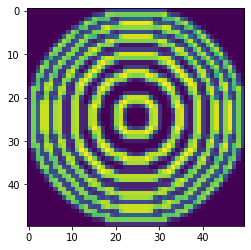

In [247]:
scale_factor = 10

img = Image.open('./circles.png').convert("L")
L = T.Compose([
    T.Resize(50),
    T.ToTensor()
])(img).unsqueeze(0)
plt.imshow(L[0].permute(1, 2, 0))

UPSAMPLING


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:42<00:00,  5.35s/it]


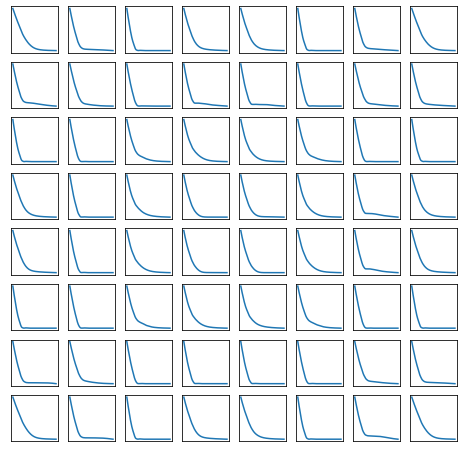

DEBLURRING


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:42<00:00,  5.31s/it]


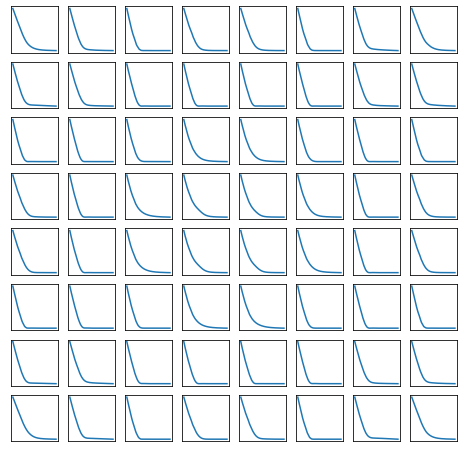

In [248]:
kernel_size = 15
stride = 5

Hb = nn.Upsample(scale_factor=scale_factor, mode='bicubic')(L)
H_tilde = upsample(L, kernel_size, stride, scale_factor=scale_factor)
Lb = T.GaussianBlur(11)(H_tilde)
Lb = F.interpolate(Lb.unsqueeze(0), scale_factor=(1/scale_factor), mode='bilinear', antialias=True)
H = deblur(H_tilde.unsqueeze(0), L, Lb, kernel_size, stride)

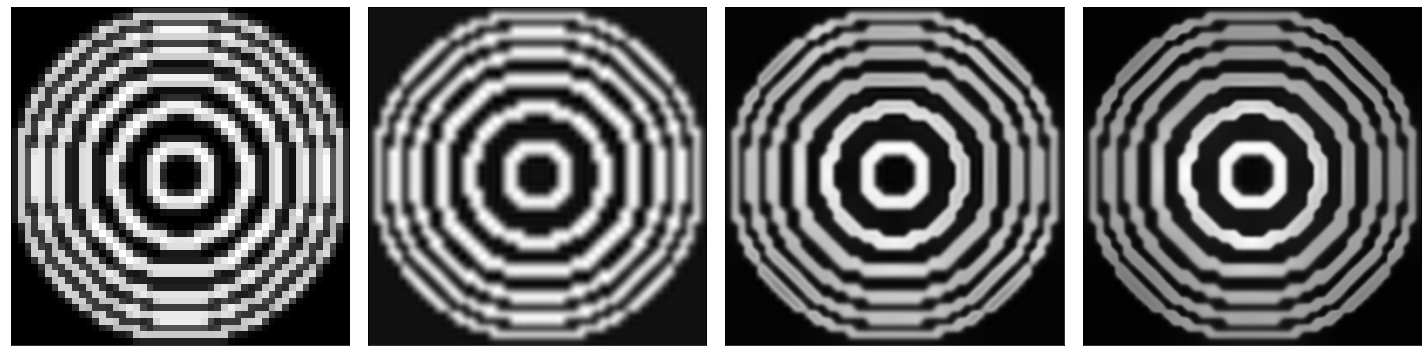

In [249]:
f, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(L.squeeze(), cmap='gray')
ax[1].imshow(Hb.detach().numpy().squeeze(), cmap='gray')
ax[2].imshow(H_tilde.detach().numpy().squeeze(), cmap='gray')
ax[3].imshow(H.detach().numpy().squeeze(), cmap='gray')

# ax[0].set_title(f'LR {L.squeeze().shape}')
# ax[1].set_title(f'Bicubic {Hb.detach().numpy().squeeze().shape}')
# ax[2].set_title(f'Upsampled {H_tilde.detach().numpy().squeeze().shape}')
# ax[3].set_title(f'H {H.detach().numpy().squeeze().shape}')

remove_axes(ax)
plt.tight_layout()

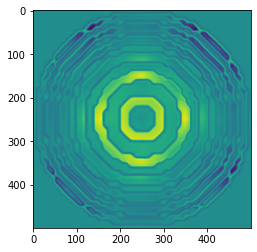

In [251]:
diff = H.detach().numpy().squeeze() - H_tilde.detach().numpy().squeeze()
plt.imshow(diff)